In [9]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import os

########################################
#PARAMETERS
nTimeSteps = 60; #at 60 Hz
epochs = 300
minibatch_size= 10
samplenum = 1000
samplenum_test = 5000
hiddenlayers = [280, 350]
samples_per_file = 1000
input_size = 25 # 0:3 target, 3:9 q, 9:15 qdot, 15:21 qddot, 21:25 p_now
output_size = 4*nTimeSteps
use_case = 'cube-drag'
learning_rate = 0.001
LRdecay = 0.7
model_file_path = '../Trained_Models/'
model_file_path_passive = '../Trained_Models/state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt'
sample_file_path = f'../Data/Samples/data_cube-drag_{nTimeSteps}tsteps_2315/'
simulation_file_path = '../Data/Simulations/cube-drag.sim'
objective_file_path = f'../Data/Objectives/cube-drag.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

############################################
#LOAD SIMULATION PYDDE_V2
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init_0 = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init_0[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init_0)
r = dyn.r(state_init, p_init_0)
dr = dyn.dr_dp(state_init, p_init_0)
dq = dyn.dq_dp(state_init, p_init_0)

['data_1.json', '.DS_Store', 'data_0.json', 'data_10.json', 'data_7.json', 'data_test', 'cube.out', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_14.json', 'Sampling_cube-drag.py', 'data_2.json']


In [10]:
#########################################
#LOAD TRAINING SAMPLES WITHOUT QDDOT
# 0:3 target, 3:9 q, 9:15 qdot, 15:19 p_now
number_of_files = len(os.listdir(sample_file_path))-5
samplenum_temp = samples_per_file*number_of_files

p = np.zeros((samplenum_temp, dyn.nParameters*nTimeSteps))
input = np.zeros((samplenum_temp, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 21:25] = np.array(p_now_i) - [input[filenum*filesize+i, 3], input[filenum*filesize+i, 5], input[filenum*filesize+i, 6], input[filenum*filesize+i, 8]]

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
p_data = p[~(p == 0).all(1)]
data = input[~(input == 0).all(1)]
print(input.shape)
print(p.shape)
'''
#normalize qddot
def minmaxscale(input, extrema):
    if extrema == None:
        maximas= []
        minimas= []
        for i in range(len(input[0, :])):
            maximas.append(np.max(input[:,i]))
            minimas.append(np.min(input[:,i]))
        max = np.max(maximas)
        min = np.min(minimas)
        extrema = np.max([max, np.linalg.norm(min)])
        scaled = (input+extrema)/(2*extrema)
        return scaled, extrema
    else:
        scaled = (input+extrema)/(2*extrema)
        return scaled

data[:, 15:18], extr_qddot = minmaxscale(data[:, 15:18], None)
data[:, 18:21], extr_qddot = minmaxscale(data[:, 18:21], None)
print("15:18")
print(data[:, 15:18])
'''
'''
maximas_qddot_1 = [np.max(input[:, 15]), np.max(input[:, 16]), np.max(input[:, 17]), np.max(input[:, 18], np.max(input[:, 19], np.max(input[:, 20]]
minimas_qddot_1 = [np.min(input[:, 15]), np.min(input[:, 16]), np.min(input[:, 17]), np.min(input[:, 18], np.min(input[:, 19], np.min(input[:, 20]]
max_scale_qddot = np.max(maximas_qddot)
minscale_qddot = np.min(minimas_qddot)
extrema_qddot = np.max([max_scale_qddot, np.linalg.norm(minscale_qddot)])
print(max_scale_qddot)
print(minscale_qddot)
print(extrema_qddot)
input[:, 9:12] = (input[:, 15:21]+extrema_qddot)/(2*extrema_qddot)
'''
#print("18:21")
#print(data[:, 18:21])
# Splitting the dataset into the Training set and Test set

input = torch.tensor(input).float()
p = torch.tensor(p).float()

Shape of input: (15000, 25)
Shape of p: (15000, 240)
(15000, 25)
(15000, 240)


In [11]:
#########################################
#LOAD TEST SAMPLES
# 0:3 target, 3:9 q, 9:15 qdot, 15:19 p_now
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test_temp = 1000*number_of_files_test

p_test = np.zeros((samplenum_test_temp, dyn.nParameters*nTimeSteps))
input_test = np.zeros((samplenum_test_temp, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p_test[filenum*filesize+i, :] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input_test[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input_test[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
           input_test[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input_test[filenum*filesize+i, 21:25] = np.array(p_now_i) - [input_test[filenum*filesize+i, 3],input_test[filenum*filesize+i, 5], input_test[filenum*filesize+i, 6], input_test[filenum*filesize+i, 8]]

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
p_test = p_test[~(input_test == 0).all(1)]
input_test = input_test[~(input_test == 0).all(1)]
print(f'Shape of DATA_TEST after removing failed samples:{input_test.shape}')
print(f'Shape of P_TEST after removing failed samples:{p_test.shape}')
input_test = input_test[0:samplenum_test, :]
p_test = p_test[0:samplenum_test, :]

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()

print(f'Shape of input: {input_test.shape}')
print(f'Shape of p: {p_test.shape}')

Shape of input_test: (5000, 25)
Shape of p_test: (5000, 240)
Shape of DATA_TEST after removing failed samples:(5000, 25)
Shape of P_TEST after removing failed samples:(5000, 240)
Shape of input: torch.Size([5000, 25])
Shape of p: torch.Size([5000, 240])


In [2]:
#########################################
#LOAD TRAINING SAMPLES 
'''
number_of_files = len(os.listdir(sample_file_path))-3
samplenum = samples_per_file*number_of_files

p = np.zeros((dyn.nParameters*nTimeSteps, samplenum))
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 21:25] = np.array(p_now_i)
p = p.transpose()

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
p_data = p[~(p == 0).all(1)]
data = input[~(input == 0).all(1)]
print(input.shape)
print(p.shape)

#normalize qddot
def minmaxscale(input, extrema):
    if extrema == None:
        maximas= []
        minimas= []
        for i in range(len(input[0, :])):
            maximas.append(np.max(input[:,i]))
            minimas.append(np.min(input[:,i]))
        max = np.max(maximas)
        min = np.min(minimas)
        extrema = np.max([max, np.linalg.norm(min)])
        scaled = (input+extrema)/(2*extrema)
        return scaled, extrema
    else:
        scaled = (input+extrema)/(2*extrema)
        return scaled

data[:, 15:18], extr_qddot = minmaxscale(data[:, 15:18], None)
data[:, 18:21], extr_qddot = minmaxscale(data[:, 18:21], None)
print("15:18")
print(data[:, 15:18])

maximas_qddot_1 = [np.max(input[:, 15]), np.max(input[:, 16]), np.max(input[:, 17]), np.max(input[:, 18], np.max(input[:, 19], np.max(input[:, 20]]
minimas_qddot_1 = [np.min(input[:, 15]), np.min(input[:, 16]), np.min(input[:, 17]), np.min(input[:, 18], np.min(input[:, 19], np.min(input[:, 20]]
max_scale_qddot = np.max(maximas_qddot)
minscale_qddot = np.min(minimas_qddot)
extrema_qddot = np.max([max_scale_qddot, np.linalg.norm(minscale_qddot)])
print(max_scale_qddot)
print(minscale_qddot)
print(extrema_qddot)
input[:, 9:12] = (input[:, 15:21]+extrema_qddot)/(2*extrema_qddot)

#print("18:21")
#print(data[:, 18:21])
# Splitting the dataset into the Training set and Test set
print(input[2,:])
print(p[2,:])
exit()
from sklearn.model_selection import train_test_split
input, input_test, p, p_test = train_test_split(data, p_data, test_size = testsize)

input = torch.tensor(input).float()
p = torch.tensor(p).float()

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()
print(input.shape)
print(p.shape)
samplenum= len(p[:,0])
'''

Shape of input: (20000, 25)
Shape of p: (20000, 240)
(20000, 25)
(20000, 240)
[ 3.71218271e-01  2.68342694e-02  1.17474800e-01  4.83247394e-01
  3.01403010e-02  4.14151517e-01  4.66593603e-01  4.27063648e-01
  1.66635682e+00  1.64243552e-01 -3.80047382e-02 -2.84005067e-02
 -9.15824192e+00 -6.74045515e+00  5.25854518e-01 -1.02473731e+00
 -8.23622294e-01  1.17874332e+00 -4.03282349e+00 -6.52527289e+00
 -7.09841776e+01 -3.42312289e-01  5.39304601e-01 -4.52906622e-01
  4.39399922e-01]
[-0.33852213  0.5394515  -0.44973886  0.43716144 -0.30885542  0.53748377
 -0.42243664  0.42336106 -0.28539779  0.53385466 -0.39978945  0.41712671
 -0.26663815  0.52980897 -0.38178179  0.41674721 -0.25139402  0.52604245
 -0.36791311  0.41981242 -0.23846086  0.52284518 -0.35718196  0.42342155
 -0.22664474  0.52007854 -0.34814466  0.42514758 -0.21582492  0.51751062
 -0.33965147  0.42639332 -0.20595473  0.5151553  -0.33163444  0.42733162
 -0.19691349  0.51301326 -0.32400054  0.42812746 -0.18852153  0.51107092
 -0

In [14]:
#########################################
#LOAD TEST SAMPLES
'''
# target (0:3), q (3:9), qdot (9:15), qddot (15:21), p_now (21:25) 
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = samples_per_file*number_of_files_test

p_test = np.zeros((dyn.nParameters*nTimeSteps, samplenum_test))
input_test = np.zeros((samplenum_test, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p_test[:, filenum*filesize+i] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input_test[filenum*filesize+i, 3:9] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input_test[filenum*filesize+i, 9:15] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input_test[filenum*filesize+i, 15:21] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input_test[filenum*filesize+i, 21:25] = np.array(p_now_i)
p_test = p_test.transpose()

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
input_test = input_test[~(input_test == 0).all(1)]
p_test = p_test[~(p_test == 0).all(1)]
print(input_test.shape)
print(p_test.shape)

#normalize qddot
input_test[:, 15:18] = minmaxscale(input_test[:, 15:18], extr_qddot1)
input_test[:, 18:21] = minmaxscale(input_test[:, 18:21], extr_qddot2)
print(input[:, 18:21])

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()
'''

def findnan(data):
    input=data.detach().clone().numpy()
    for i in range(len(input[:,0])):
        for j in range(len(input[0,:])):
            if np.isnan(input[i,j]):
                print(f'Index{j},{i} is a nan')
    return None
def findnantorch(data):
    if torch.any(torch.isnan(data)):
        print(f'NAN found')
    return None

epoch:   0/300    LR:   0.010000  loss: 78.83693695
epoch:  60/300    LR:   0.002401  loss: 73.58695984
epoch: 120/300    LR:   0.000576  loss: 67.13832092
epoch: 180/300    LR:   0.000138  loss: 65.52106476
epoch: 240/300    LR:   0.000033  loss: 65.15868378
epoch: 299 final loss: 65.07625580

Training completed. Total duration: 13.355 min


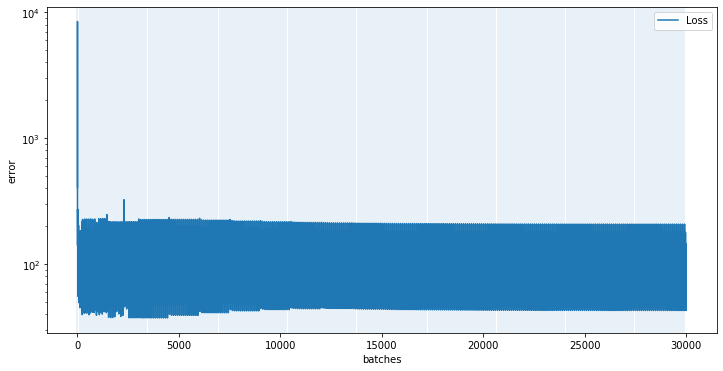

In [12]:
################################
#BUILD MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], hiddenlayers[1])
        self.H2 = nn.Linear(hiddenlayers[1], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(input_size, output_size)

#criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
criterion = nn.MSELoss(reduction= 'sum')  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

################################################
#TRAIN THE MODEL

torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        input_i = input[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(input_i)
        #error calculation
        loss_batch = weight_c1 * criterion(p_pred, p_i)
        losses.append(loss_batch)
        optimizer.zero_grad()
        #Back Prop
        loss_batch.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    #print(loss_batch)
    if e%(epochs/5) == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch:10.8f}')

print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

##################################################
#Plot loss for each batch after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'Loss')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

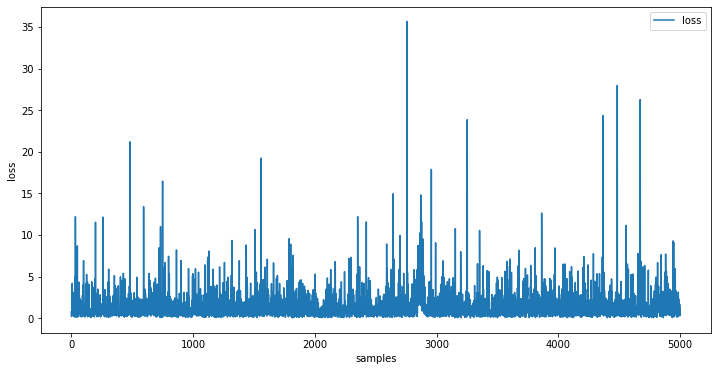

6940.996474716812


In [5]:
####################################################
#Test the data
samplenum_test = len(input_test[:,0])
losses_test= []
with torch.no_grad():
    for i in range(samplenum_test):
        p_val = model(input_test[i, :])
        loss_test = criterion(p_val,p_test[i,:])
        losses_test.append(loss_test.clone().numpy())
#plot test errors
plt.figure(figsize = [12,6])
loss_test_plot = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('samples')
plt.show()
tot_error = sum(losses_test)
print(tot_error)

## PLOTS

In [5]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(dyn.nParameters*nTimeSteps)
abs_errors_sum = torch.zeros(dyn.nParameters*nTimeSteps)
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::4]/(samplenum_test)
z_err_rel = rel_errors_sum[1::4]/(samplenum_test)

x_err = abs_errors_sum[0::4]/(samplenum_test)
z_err = abs_errors_sum[1::4]/(samplenum_test)

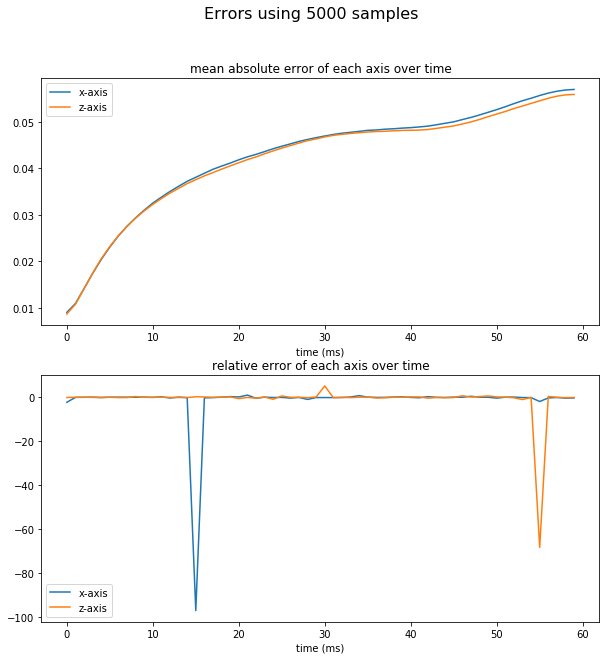

In [6]:
plt.figure(figsize = [10,10])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

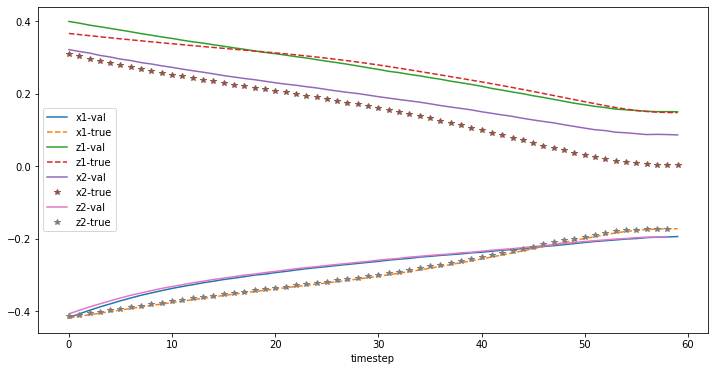

In [7]:
#x, y and z plot
randomsample = 2
with torch.no_grad():
        p_val = model(input_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::4]
        z_val = p_val[1::4]
        x_val_2 = p_val[3::4]
        z_val_2 = p_val[4::4]
        x_truth = p_truth[0::4]
        z_truth = p_truth[1::4]
        x_truth_2 = p_truth[3::4]
        z_truth_2 = p_truth[4::4]
            

plt.figure(figsize = [12,6])
plt.plot(x_val, label = 'x1-val')
plt.plot(x_truth, '--', label = 'x1-true')
plt.plot(z_val, label = 'z1-val')
plt.plot(z_truth, '--', label = 'z1-true')
plt.plot(x_val_2, label = 'x2-val')
plt.plot(x_truth_2, '*', label = 'x2-true')
plt.plot(z_val_2, label = 'z2-val')
plt.plot(z_truth_2, '*', label = 'z2-true')
plt.legend()
plt.xlabel('timestep')
plt.show()

In [8]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_passive_' + use_case + '_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = input[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

Model saved


In [35]:
#####################################################
# !!!!!!!!!!!!!!!NOT READY YET!!!!!!!!!!!!!!
#TEST THE MODEL

# Generate simulation
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#Load objective
obj = dde.InverseObjective(dyn)

#obj.loadFile(objective_file_path)
data = json.load(open(objective_file_path))
data['objectives']['pmTargetPositions'][0]['targetPos'] = ([[0.5],[0.5],[0.5]])
obj.loadJson(data)

y_target_test_= torch.tensor([0.5, 0.5, 0.5])
p_ = model(y_target_test_)
p_ = p_.detach().numpy()
newton = dde.Newton()
p_truth_ = newton.minimize(obj, p_init)
y_target_ = y_target_test_.detach().numpy()

yTraj_test_ = dyn.q(p_)
yTraj_truth_ = dyn.q(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target:\n {y_target_test_}')
print(f'\nevaluated y_end:\n {yTraj_test_.q[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth:\n {yTraj_truth_.q[-3:]}')
print(f'\ndifference of y_end:\n {np.sum(yTraj_test_.q[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted:\n {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt:\n {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target:
 tensor([0.5000, 0.5000, 0.5000])

evaluated y_end:
 [0.49432393 0.49335369 0.4951183 ]

simulated traj_opt y_end with p_truth:
 [0.49560763 0.49293486 0.49560763]

difference of y_end:
 -0.017204084384135065

last 6 entries of p predicted:
 [0.47749302 1.2182992  0.47810224 0.4774424  1.2185354  0.47826165]

last 6 entries of p from traj_opt:
 [0.47875592 1.21774452 0.47875592 0.478775   1.21785194 0.478775  ]
